In [16]:
!pip install datasets polars

In [4]:
from datasets import load_dataset

# Load the 'food' split
ds = load_dataset("openfoodfacts/product-database", split="food")

# Preview a few rows
print(ds[0])
print(ds.column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

food.parquet:   0%|          | 0.00/4.31G [00:00<?, ?B/s]

beauty.parquet:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

Generating food split: 0 examples [00:00, ? examples/s]

Generating beauty split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/54 [00:00<?, ?it/s]

{'additives_n': None, 'additives_tags': None, 'allergens_tags': ['en:nuts'], 'brands_tags': ['xx:bovetti'], 'brands': 'Bovetti', 'categories': 'Petit-déjeuners,Produits à tartiner,Produits à tartiner sucrés,Pâtes à tartiner,Pâtes à tartiner aux noisettes,Pâtes à tartiner au chocolat,Pâtes à tartiner aux noisettes et au cacao', 'categories_tags': ['en:breakfasts', 'en:spreads', 'en:sweet-spreads', 'fr:pates-a-tartiner', 'en:hazelnut-spreads', 'en:chocolate-spreads', 'en:cocoa-and-hazelnuts-spreads'], 'categories_properties': {'ciqual_food_code': 31032, 'agribalyse_food_code': 31032, 'agribalyse_proxy_food_code': 31032}, 'checkers_tags': [], 'ciqual_food_name_tags': ['chocolate-spread-with-hazelnuts'], 'cities_tags': [], 'code': '0000101209159', 'compared_to_category': 'en:cocoa-and-hazelnuts-spreads', 'complete': 0, 'completeness': 0.6875, 'correctors_tags': ['openfoodfacts-contributors', 'tacite-mass-editor', 'sebleouf', 'moon-rabbit', 'roboto-app', 'timotheeberthault'], 'countries_tag

In [5]:
from tqdm import tqdm
import pandas as pd

def extract_nutriments(item):
    nutriments_list = item.get('nutriments', None)
    nutriments = {}
    if nutriments_list and isinstance(nutriments_list, list):
        nutriments = {n['name']: n['value'] for n in nutriments_list if isinstance(n, dict) and 'name' in n and 'value' in n}
    return {
        "name": item.get("product_name", [{}])[0].get("text", "") if item.get("product_name") else "",
        "energy_kcal_100g": nutriments.get("energy-kcal", None),
        "fat_100g": nutriments.get("fat", None),
        "carbohydrates_100g": nutriments.get("carbohydrates", None),
        "sugars_100g": nutriments.get("sugars", None),
        "proteins_100g": nutriments.get("proteins", None)
    }

# Apply to dataset with progress bar
cleaned_data = [extract_nutriments(item) for item in tqdm(ds)]

# Create DataFrame
df = pd.DataFrame(cleaned_data)
print(df.head())

#DATAFRAME
df.to_csv('food_cleaned.csv', index=False)           # Save as CSV
df.to_parquet('food_cleaned.parquet')                # Save as Parquet (recommended for large data)

print("Saved as food_cleaned.csv and food_cleaned.parquet")

100%|██████████| 4137197/4137197 [2:35:07<00:00, 444.50it/s]


                                                name  energy_kcal_100g  \
0  Véritable pâte à tartiner noisettes chocolat noir        617.000000   
1                               Chamomile Herbal Tea        280.000000   
2                     Lagg's, herbal tea, peppermint          0.000000   
3                                 Linden Flowers Tea        213.320007   
4                               Herbal Tea, Hibiscus        267.000000   

   fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  
0      48.0           36.000000         32.0       8.000000  
1       0.0           70.000000          NaN       0.000000  
2       0.0            1.470000          NaN       0.000000  
3       0.0           53.330002          NaN       0.000000  
4       0.0           60.000000          NaN      66.669998  
Saved as food_cleaned.csv and food_cleaned.parquet


In [6]:
df.to_csv('food_cleaned.csv', index=False)
# or faster & smaller:
df.to_parquet('food_cleaned.parquet')

In [7]:
import pandas as pd
df = pd.DataFrame(cleaned_data)
print(df.head())  # Check if df exists and shows your cleaned data

                                                name  energy_kcal_100g  \
0  Véritable pâte à tartiner noisettes chocolat noir        617.000000   
1                               Chamomile Herbal Tea        280.000000   
2                     Lagg's, herbal tea, peppermint          0.000000   
3                                 Linden Flowers Tea        213.320007   
4                               Herbal Tea, Hibiscus        267.000000   

   fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  
0      48.0           36.000000         32.0       8.000000  
1       0.0           70.000000          NaN       0.000000  
2       0.0            1.470000          NaN       0.000000  
3       0.0           53.330002          NaN       0.000000  
4       0.0           60.000000          NaN      66.669998  


In [8]:
from sklearn.model_selection import train_test_split

# Example: Binary label for "low calorie" (<100 kcal/100g)
df['low_calorie'] = df['energy_kcal_100g'] < 100

# Features for classification (fill NaNs for ML)
X = df[['fat_100g', 'carbohydrates_100g', 'proteins_100g']].fillna(0)
y = df['low_calorie']

# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate accuracy
accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9620


In [10]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred))

# Assuming binary classification and sklearn returns:
#     [[TN, FP],
#      [FN, TP]]

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Confusion Matrix:
 [[669543   8534]
 [ 22921 126442]]
              precision    recall  f1-score   support

       False       0.97      0.99      0.98    678077
        True       0.94      0.85      0.89    149363

    accuracy                           0.96    827440
   macro avg       0.95      0.92      0.93    827440
weighted avg       0.96      0.96      0.96    827440

True Positives (TP): 126442
True Negatives (TN): 669543
False Positives (FP): 8534
False Negatives (FN): 22921


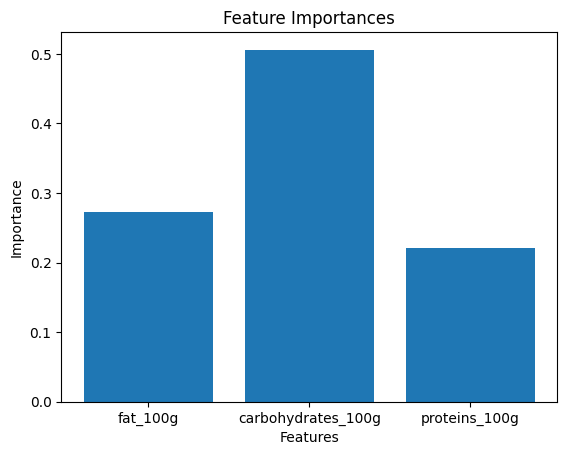

In [11]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
plt.bar(X_train.columns, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [12]:
# Drop low-importance features and retrain
selected_features = ['fat_100g', 'carbohydrates_100g']  # example, pick top features
X_selected = df[selected_features].fillna(0)
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(f"Accuracy with selected features: {clf_sel.score(X_test_sel, y_test):.4f}")

Accuracy with selected features: 0.9369


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_sel = clf_sel.predict(X_test_sel)
print(confusion_matrix(y_test, y_pred_sel))
print(classification_report(y_test, y_pred_sel))

[[659658  18419]
 [ 33828 115535]]
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    678077
        True       0.86      0.77      0.82    149363

    accuracy                           0.94    827440
   macro avg       0.91      0.87      0.89    827440
weighted avg       0.94      0.94      0.94    827440



In [14]:
import joblib
# Drop low-importance features and retrain
selected_features = ['fat_100g', 'carbohydrates_100g']  # example, pick top features
X_selected = df[selected_features].fillna(0)
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)

joblib.dump(clf_sel, 'low_calorie_classifier_selected.joblib')

['low_calorie_classifier_selected.joblib']

In [15]:
# OPTUNA and HYPERBAND with tqdm Progress Bar
#  Fully Resumable  Crash-Safe • Fast


!pip install optuna tqdm

import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tqdm
import joblib
import pandas as pd
import os


# -----------------------------
# LOAD DATA SAFELY
# -----------------------------
if "df" not in globals():
    print("Loading dataset...")
    df = pd.read_parquet("food_cleaned.parquet")   # CHANGE to your file

selected_features = ['fat_100g', 'carbohydrates_100g']

X = df[selected_features].fillna(0)
y = (df['energy_kcal_100g'] < 100).astype(int)

X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# -----------------------------
# OPTUNA STORAGE (Auto-resume)
# -----------------------------
study_name = "rf_hyperband_study"
storage = "sqlite:///rf_hyperband.db"

try:
    study = optuna.load_study(study_name=study_name, storage=storage)
    print("Loaded existing study -> Resuming!")
except:
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="maximize",
        sampler=TPESampler(seed=42),
        pruner=HyperbandPruner()
    )
    print("Created new study.")


# -----------------------------
# OBJECTIVE FUNCTION
# -----------------------------
def objective(trial):

    # Hyperparameters to search
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )

    # Cross-validation accuracy
    scores = cross_val_score(model, X_train_sel, y_train, cv=3, scoring="accuracy")
    acc = scores.mean()

    trial.report(acc, step=0)

    # Prune bad trials early
    if trial.should_prune():
        raise optuna.TrialPruned()

    return acc


# -----------------------------
# RUN OPTIMIZATION WITH tqdm
# -----------------------------
N_TRIALS = 100  # adjust as you want

print("\nRunning Optuna Hyperband tuning with tqdm...\n")

with tqdm(total=N_TRIALS, desc="Hyperband Tuning Progress") as pbar:

    completed_trials = len(study.trials)

    # Resume progress bar if existing study already had trials
    pbar.update(completed_trials)

    def callback(study, trial):
        pbar.update(1)

    # Optimize
    study.optimize(
        objective,
        n_trials=N_TRIALS,
        gc_after_trial=True,
        callbacks=[callback]
    )


# -----------------------------
# BEST PARAMETERS & FINAL MODEL
# -----------------------------
print("\nBest Score:", study.best_value)
print("Best Params:", study.best_params)

best_model = RandomForestClassifier(
    **study.best_params,
    n_jobs=-1,
    random_state=42
)
best_model.fit(X_train_sel, y_train)

joblib.dump(best_model, "best_rf_model_optuna.joblib")
print("\nSaved best model: best_rf_model_optuna.joblib")

# Save full trial history
df_results = study.trials_dataframe()
df_results.to_csv("optuna_tuning_results.csv", index=False)
print("Saved tuning log: optuna_tuning_results.csv")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00


[I 2025-11-14 07:13:37,490] A new study created in RDB with name: rf_hyperband_study


Created new study.

Running Optuna Hyperband tuning with tqdm...



Hyperband Tuning Progress:   1%|          | 1/100 [34:58<57:41:46, 2098.04s/it][W 2025-11-14 08:41:51,847] Trial 1 failed with parameters: {'n_estimators': 267, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-1948313749.py", line 78, in objective
    scores = cross_val_score(model, X_train_sel, y_train, cv=3, scoring="accuracy")
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", 

KeyboardInterrupt: 